In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import levene
from statsmodels.stats.diagnostic import het_breuschpagan
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('C:\\Users\\tilleymusprime\\Desktop\\mcclean1.csv')

In [4]:
#Int his workbook, we will be looking at the Right tackle Position
rt = df[df['Position'] == 'RT']

In [5]:
rtcorr = rt.corr()

In [6]:
rtpos = rtcorr[rtcorr['Overall Rating'] >= 0.5]

In [7]:
rtneg = rtcorr[rtcorr['Overall Rating'] <= -0.5]

In [8]:
print(rtpos['Overall Rating'], rtneg['Overall Rating'])

Awareness          0.888010
Impact Blocking    0.563743
Overall Rating     1.000000
Pass Block         0.710810
Run Block          0.587632
Strength           0.589107
Name: Overall Rating, dtype: float64 Series([], Name: Overall Rating, dtype: float64)


In [11]:
#Here are the significant correlations
rtsig = rt[['Awareness', 'Impact Blocking', 'Pass Block', 'Run Block', 'Strength']]
X = add_constant(rtsig)
pd.Series([variance_inflation_factor(X.values, i)
          for i in range(X.shape[1])],
         index=X.columns)
#Since all of our VIF scores are below 5, we can move on to the statistical summary testing

const              721.097577
Awareness            1.730022
Impact Blocking      1.271404
Pass Block           1.453986
Run Block            1.189956
Strength             1.356794
dtype: float64

In [13]:
RT = sm.OLS(rt['Overall Rating'], rtsig).fit()
print(RT.summary())
#It looks like strength is not a significant variable

                            OLS Regression Results                            
Dep. Variable:         Overall Rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.092e+04
Date:                Sat, 21 Jul 2018   Prob (F-statistic):          2.43e-196
Time:                        01:22:58   Log-Likelihood:                -230.11
No. Observations:                 124   AIC:                             470.2
Df Residuals:                     119   BIC:                             484.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Awareness           0.3624      0.014     

In [15]:
rtsig1 = rt[['Awareness', 'Impact Blocking', 'Pass Block', 'Run Block']]
RT1 = sm.OLS(rt['Overall Rating'], rtsig1).fit()
print(RT1.summary())
#it looks like all of our variables are significant now and the AIC went down slightly

                            OLS Regression Results                            
Dep. Variable:         Overall Rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.381e+04
Date:                Sat, 21 Jul 2018   Prob (F-statistic):          1.28e-198
Time:                        01:24:35   Log-Likelihood:                -230.48
No. Observations:                 124   AIC:                             469.0
Df Residuals:                     120   BIC:                             480.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Awareness           0.3645      0.013     

In [16]:
def model():
    pv=0.3645* rt['Awareness']+ 0.0868*rt['Impact Blocking']+ 0.2190*rt['Pass Block']+ 0.3042*rt['Run Block']
    return pv

In [17]:
rt['Predicted Value'] = model()
rt['Residual'] = rt['Predicted Value'] - rt['Overall Rating']

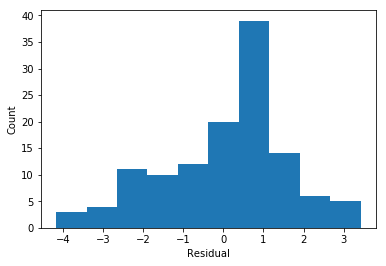

In [18]:
plt.hist(rt['Residual'])
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

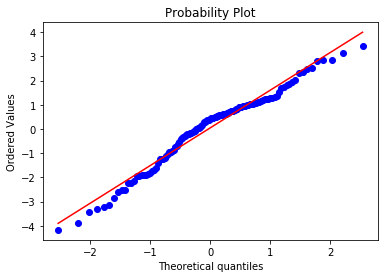

In [19]:
stats.probplot(rt['Residual'], plot=plt)
plt.show()
#There does not appear to be any outliers in the residuals

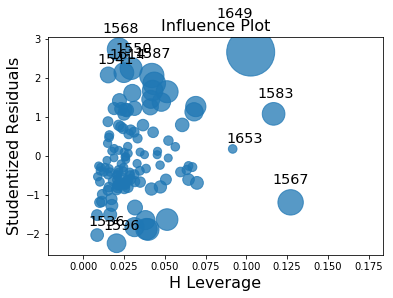

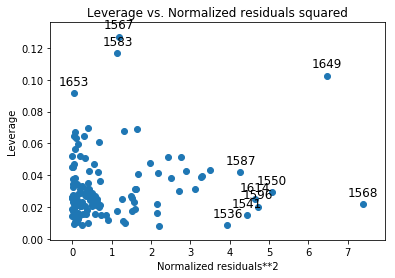

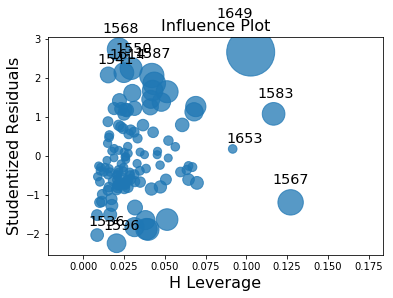

In [20]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(RT1)
influence_plot(RT1)

In [22]:
rtul = rt.drop(df.index[[1568, 1567, 1649]])
rtulsig = rtul[['Awareness', 'Impact Blocking', 'Pass Block', 'Run Block']]
RT2 = sm.OLS(rtul['Overall Rating'], rtulsig).fit()
print(RT2.summary())
#It looks like removing those data points lowered the AIC score
#All of our variables are still significantly different from 0

                            OLS Regression Results                            
Dep. Variable:         Overall Rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.895e+04
Date:                Sat, 21 Jul 2018   Prob (F-statistic):          2.99e-196
Time:                        01:30:02   Log-Likelihood:                -218.21
No. Observations:                 121   AIC:                             444.4
Df Residuals:                     117   BIC:                             455.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Awareness           0.3561      0.013     

In [23]:
def model():
    pv=0.3561*rtul['Awareness']+ 0.0865*rtul['Impact Blocking']+ 0.2429*rtul['Pass Block']+ 0.2875*rt['Run Block']
    return pv

In [25]:
rtul['Predicted Value'] = model()
rtul['Residual'] = rtul['Predicted Value'] - rtul['Overall Rating']

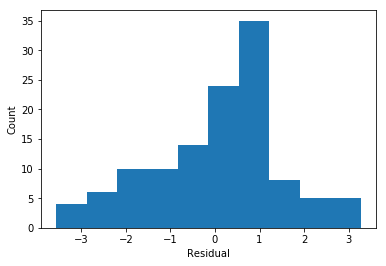

In [27]:
plt.hist(rtul['Residual'])
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

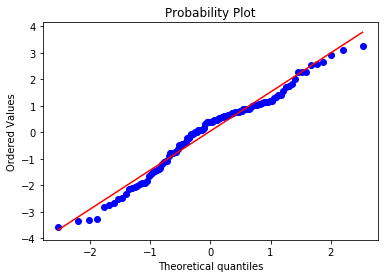

In [26]:
stats.probplot(rtul['Residual'], plot=plt)
plt.show()
#There does not appear to be any outliers in the residuals

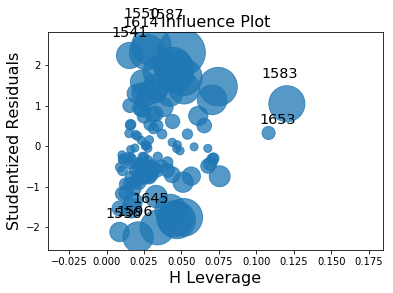

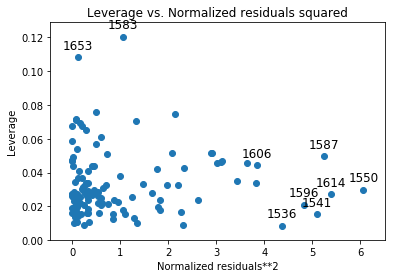

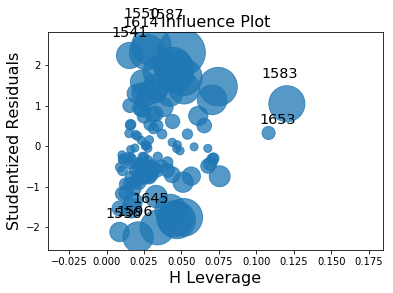

In [29]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(RT2)
influence_plot(RT2)
#There are no high residuals that also have high leverage so we will keep this set of data the way it is

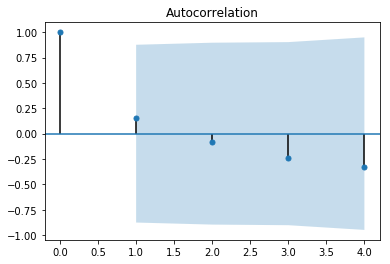

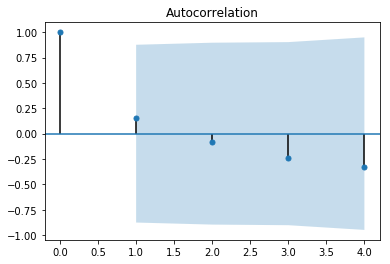

In [31]:
#Now, we will test for autocorrelation.  Acording to the Durbin Watson statistic, we should be fine but let's double check
rtulcorr1 = rtul[['Overall Rating', 'Awareness', 'Impact Blocking', 'Pass Block', 'Run Block']].corr()
plot_acf(rtulcorr1['Overall Rating'])
#Everything appears to be within the bandwidth

In [33]:
#Finally, we will check for heteroskedasticity with the breusch-pagan test

het_breuschpagan(rtul['Residual'], rtulsig)
#Based on the low p-values, we can reject the null that there is significant heteroskedasticity in the model

(46.65173507880769,
 4.121974574734739e-10,
 18.353666390218187,
 9.965030036325172e-12)

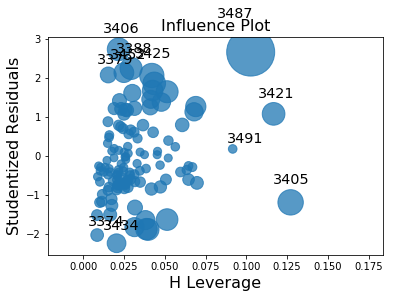

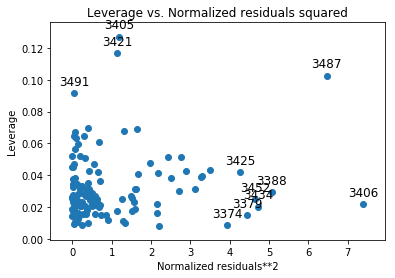

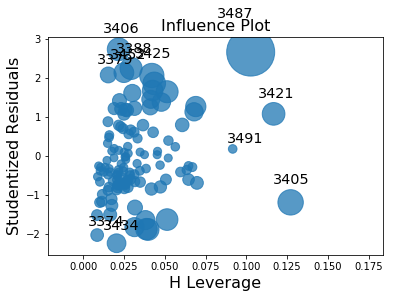

In [35]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(RT2)
influence_plot(RT2)
#It looks like there we will need to remove point 3487 and retest the model

In [34]:
X_train, X_test, y_train, y_test = train_test_split(rtulsig, rtul['Overall Rating'], test_size = 0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
rtcv = cross_val_score(reg, rtulsig, rtul['Overall Rating'], cv =5)
rtcv_mean = np.mean(rtcv)
print(rtcv, rtcv_mean)

[0.96389421 0.98845698 0.98294458 0.97678278 0.93379193] 0.9691740980105218


In [35]:
rtclean1 = rtul[['Overall Rating', 'Awareness', 'Impact Blocking', 'Pass Block', 'Run Block']]
rtdesc = rtclean1.describe()
rtdesc.to_csv('C:\\Users\\tilleymusprime\\Desktop\\rtdesc.csv')